In [134]:
import sys
sys.path.insert(0, '/Users/eman/Documents/code_projects/rbig/')

from rbig.univariate import MarginalUniformization
from rbig.data import ToyData


import numpy as np
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
import warnings
from sklearn.utils import check_random_state
from sklearn.exceptions import DataConversionWarning
from sklearn.utils.validation import column_or_1d
import scipy
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt
plt.style.use('ggplot')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [146]:
seed = 123
rng = np.random.RandomState(seed=seed)

data = ToyData('moons', 10000, 0.1, 123).generate_samples()
X = data[:, 0]
Y = data[:, 1]

### Bounds Check

In [49]:
def check_bounds(X=None, bounds=([-np.inf, np.inf]), extend=True):
    """Checks the bounds. Since we are going from an unbound domain to
    a bounded domain (Random Dist to Uniform Dist) we are going to have
    a problem with defining the boundaries. This function will either 
    have set boundaries or extend the boundaries with with a percentage.
    
    Parameters
    ----------
    X : array-like, default=None
    
    bounds : int or array-like [low, high]
    
    extend : bool, default=True
    
    Returns
    -------
    bounds : array-like
    
    References
    ---------
    https://github.com/davidinouye/destructive-deep-learning/blob/master/ddl/univariate.py#L506
    """
    
    
    default_support = np.array([-np.inf, np.inf])
    
    # Case I - Extension
    if np.isscalar(bounds):
        
        
        if X is None:
            # If no X, return default support (unbounded domain)
            return default_support
        else:
            # extend the domain by x percent
            percent_extension = bounds
            
            # Get the min and max for the current domain
            domain = np.array([np.min(X), np.max(X)])
            
            # Get the mean value of the domain
            center = np.mean(domain)
            
            # Extend the domain on either sides
            domain = (1 + percent_extension) * (domain - center) + center
            
            return domain
    
    
    # Case II - Directly compute
    else:
        domain = column_or_1d(bounds).copy()
        
        if domain.shape[0] != 2:
            raise ValueError('Domain should either be a two element array-like' 
                             ' or a scalar indicating percentage extension of domain.')
        
        return domain

    from sklearn.exceptions import DataConversionWarning

def check_X(X, bounds, inverse=False):
    
    bounds = check_bounds(X, bounds)
    
    if np.any(X <= bounds[0]) or np.any(X >= bounds[1]):
        warnings.warn(BoundaryWarning(
            'Input to random variable function has at least one value outside of bounds '
            'but all inputs should be in (bounds[0], bounds[1]) exclusinve. Bounding '
            'values away from bounds[0] and bounds[1].'
        ))
        
        X = make_interior(X, bounds)
    return X
def make_interior(X, bounds, eps=None):
    """Scale/Shift data to fit in the open interval given by bounds.
    
    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)
        Data matrix
    
    bounds : array-like, shape (2,)
        Minimum and maximum of bounds.
    
    eps : float, optional
        Epsilon for clipping, defaults to ``np.info(X.dtype).eps``
        
    Returns
    -------
    X : array, shape (n_samples, n_features)
        Data matrix after possible modification
    """
    X = check_floating(X)
    
    if eps is None:
        eps = np.finfo(X.dtype).eps
        
    left = bounds[0] + np.abs(bounds[0] * eps)
    right = bounds[1] - np.abs(bounds[1] * eps)
    return np.minimum(np.maximum(X, left), right)

### Histogram Uniformization

In [140]:
# Check if X is within Bounds
print(X.min(), X.max())
# X_ = check_X(X, bounds)
print(X.min(), X.max())

-1.258442446989061 2.3001560604849707
-1.258442446989061 2.3001560604849707


In [141]:
# # Check Bounds
# print(bounds)

# bounds_ = check_bounds(X, bounds)

# print(bounds_)

#### Bin Edges and Bin Centers

In [142]:
def bin_estimation(X, rule='scott'):
    
    n_samples = X.shape[0]
    
    if rule == 'sqrt':
        nbins = np.sqrt(n_samples)
    elif rule == 'scott':
        nbins = (3.49 * np.std(X)) / np.cbrt(n_samples)
    elif rule == 'sturge':
        nbins = 1 + np.log2(n_samples)
    elif rule == 'rice':
        nbins = 2 * np.cbrt(n_samples)
    else:
        raise ValueError(f"Unrecognized rule: {rule}")
        
    
    return int(np.ceil(nbins))

In [143]:
nbins = bin_estimation(X, rule='sqrt')
print(f"Estimated nbins: {nbins}")

Estimated nbins: 100


In [149]:
class MarginalUniformization(BaseEstimator, TransformerMixin):
    def __init__(self, bins_est='sqrt', pdf_extension=0.1, cdf_precision=1000, alpha=1e-6):
        self.bins_est = bins_est
        self.pdf_extension = pdf_extension
        self.cdf_precision = cdf_precision
        self.alpha = alpha
    def fit(self, X):
        nbins = bin_estimation(X, rule=self.bins_est)
        # Get Histogram (Histogram PDF, Histogtam bins)
        hpdf, hbins = np.histogram(X, bins=nbins)
        hpdf = np.array(hpdf, dtype=float)
        hpdf += self.alpha
        assert(len(hpdf) == nbins)
        # CDF
        hcdf = np.cumsum(hpdf)
        hcdf = (1 - 1 / X.shape[0]) * hcdf / X.shape[0]
        # Get Bin Widths
        hbin_widths = hbins[1:] - hbins[:-1]
        hbin_centers = 0.5 * (hbins[:-1] + hbins[1:])
        assert(len(hbin_widths) == nbins)
        # Get Bin StepSizde
        bin_step_size = hbins[2] - hbins[1]

        # Normalize hpdf
        hpdf = hpdf / float(np.sum(hpdf * hbin_widths))


        # Handle Tails of PDF
        hpdf = np.hstack([0.0, hpdf, 0.0])
        hpdf_support = np.hstack([
            hbin_centers[0] - bin_step_size,
            hbin_centers,
            hbin_centers[-1] + bin_step_size
        ])

        # hcdf = np.hstack([0.0, hcdf])
        domain_extension = 0.1
        precision = 1000
        old_support = np.array([X.min(), X.max()])

        support_extension = (domain_extension / 100) * abs(np.max(X) - np.min(X))
        # old_support = np.array([X.min(), X.max()])

        old_support = np.array([X.min(), X.max()])
        new_support = (1 + domain_extension) * (old_support - X.mean()) + X.mean()

        new_support = np.array([
            X.min() - support_extension, 
            X.max() + support_extension
        ])
        
        # Define New HPDF support
        hpdf_support_ext = np.hstack([
            X.min() - support_extension, 
            X.min(), 
            hbin_centers + bin_step_size, 
            X.max() + support_extension + bin_step_size
        ])

        # Define New HCDF
        hcdf_ext = np.hstack([
            0.0, 
            1.0 / X.shape[0], 
            hcdf, 
            1.0
        ])
        # Define New support for hcdf
        hcdf_support = np.linspace(hpdf_support_ext[0], hpdf_support_ext[-1], precision)
        self.hcdf_support = hcdf_support
        # Interpolate HCDF with new precision
        hcdf_ext = np.interp(hcdf_support, hpdf_support_ext, hcdf_ext, )
        self.hcdf = hcdf_ext
        self.hpdf = hpdf
        self.hpdf_support = hpdf_support

        return self
    
    def transform(self, X):
        return np.interp(X, self.hcdf_support, self.hcdf)
    
    def inverse_transform(self, X):
        return np.interp(X, self.hcdf, self.hcdf_support)
    
    def logpdf(self):
        return np.log(self.hpdf[1:-1])

[-4.77032742 -4.07718041 -3.92302975 -2.65006418 -2.31359195 -1.86160684
 -1.55145191 -1.26376985 -1.00912763 -0.9344661  -0.97859091 -0.96366526
 -1.38030366 -1.08144829 -1.29422905 -1.39160322 -1.57848059 -1.56487493
 -1.36913036 -1.69455276 -1.66424741 -1.62044478 -1.77459546 -1.66424741
 -1.74180564 -1.7258053  -1.69455276 -2.15536795 -1.75806616 -1.53820669
 -1.67928528 -1.60626015 -1.38030366 -1.23421104 -0.95628515 -0.79376622
 -0.81908403 -0.66493335 -0.58573631 -0.65400428 -0.7813437  -0.58573631
 -0.81269423 -0.78753567 -1.05675568 -0.8516602  -1.07314949 -1.1067661
 -1.00912763 -0.9060954  -0.87850745 -1.05675568 -0.91311298 -0.98613811
 -0.94895911 -0.85830474 -0.94895911 -0.97859091 -0.82551492 -0.81908403
 -0.42220267 -0.62719302 -0.68155423 -0.61666661 -0.86499373 -1.0406263
 -1.00912763 -1.45009942 -1.62044478 -1.60626015 -1.75806616 -1.57848059
 -1.82588876 -1.63483352 -1.55145191 -1.63483352 -1.82588876 -1.53820669
 -1.99773901 -1.75806616 -1.66424741 -1.53820669 -1.5

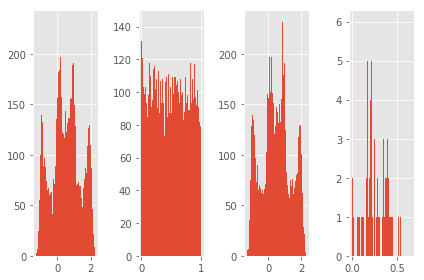

In [151]:
muni_model = MarginalUniformization()
muni_model.fit(X);

X_uni = muni_model.transform(X)
X_approx = muni_model.inverse_transform(X_uni)
logpdf = muni_model.logpdf()
print(logpdf)
X_uni.min(), X_uni.max()

fig, ax = plt.subplots(ncols=4)

ax[0].hist(X, bins=100)
ax[1].hist(X_uni, bins=100)
ax[2].hist(X_approx, bins=100)
ax[3].hist(muni_model.hpdf, bins=100)
plt.tight_layout()
plt.show()

In [54]:
# Get Histogram (Histogram PDF, Histogtam bins)
hpdf, hbins = np.histogram(X, bins=nbins)
assert(len(hpdf) == nbins)

# CDF
hcdf = np.cumsum(hpdf)
hcdf = (1 - 1 / X.shape[0]) * hcdf / X.shape[0]

# Get Bin Widths
hbin_widths = hbins[1:] - hbins[:-1]
hbin_centers = 0.5 * (hbins[:-1] + hbins[1:])
assert(len(hbin_widths) == nbins)

# Get Bin StepSizde
bin_step_size = hbins[2] - hbins[1]

# Normalize hpdf
hpdf = hpdf / float(np.sum(hpdf * hbin_widths))


# Handle Tails of PDF
hpdf = np.hstack([0.0, hpdf, 0.0])
hpdf_support = np.hstack([
    hbin_centers[0] - bin_step_size,
    hbin_centers,
    hbin_centers[-1] + bin_step_size
])

# hcdf = np.hstack([0.0, hcdf])
print(f"PDF: {hpdf.min()}, {hpdf.max()}, {hpdf.shape}")
print(f"PDF Support: {hpdf_support.min()}, {hpdf_support.max()}, {hpdf_support.shape}")

PDF: 0.0, 0.4482673830041965, (73,)
PDF Support: -0.053388421007647596, 7.656295867950861, (73,)


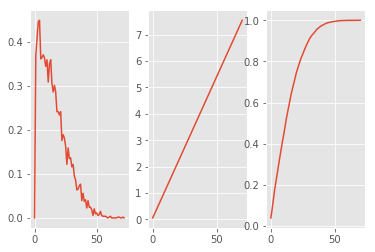

In [55]:
fig, ax = plt.subplots(ncols=3)
ax[0].plot(hpdf)
ax[1].plot(hbin_centers)
ax[2].plot(hcdf)
plt.show()

#### Support Extension

Here we want to extend the domain of the support for the uniform distribution. We have a parameter called `domain_extension` which gives a parameter (in %) for the amount the domain gets shifted.

In [56]:
domain_extension = 0.1
precision = 1000
old_support = np.array([X.min(), X.max()])

support_extension = (domain_extension / 100) * abs(np.max(X) - np.min(X))
print(f"Support Extension: {support_extension}")
# old_support = np.array([X.min(), X.max()])

old_support = np.array([X.min(), X.max()])
new_support = (1 + domain_extension) * (old_support - X.mean()) + X.mean()
print(f"Old Support: {old_support}")
print(f"New Support: {new_support}")

Support Extension: 0.007602605340500752
Old Support: [1.51053221e-04 7.60275639e+00]
New Support: [-0.15772027  8.2051456 ]


In [57]:
new_support = np.array([
    X.min() - support_extension, 
    X.max() + support_extension
])

new_support

array([-7.45155212e-03,  7.61035900e+00])

#### CDF

(74,)
(74,)


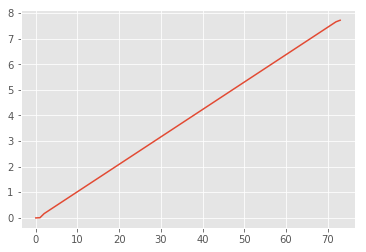

In [58]:
# Define New HPDF support
hpdf_support_ext = np.hstack([
    X.min() - support_extension, 
    X.min(), 
    hbin_centers + bin_step_size, 
    X.max() + support_extension + bin_step_size
])
print(hpdf_support_ext.shape)


# Define New HCDF
hcdf_ext = np.hstack([
    0.0, 
    1.0 / X.shape[0], 
    hcdf, 
    1.0
])
print(hcdf_ext.shape)

plt.plot(hpdf_support_ext)

-0.007451552119269835 7.71743794752024


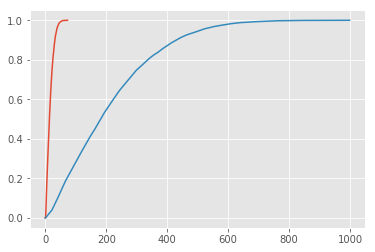

In [59]:
plt.plot(hcdf_ext)
# Define New support for hcdf
hcdf_support = np.linspace(hpdf_support_ext[0], hpdf_support_ext[-1], precision)
print(hcdf_support.min(), hcdf_support.max())

# Interpolate HCDF with new precision
hcdf_ext = np.interp(hcdf_support, hpdf_support_ext, hcdf_ext, )
plt.plot(hcdf_ext)
# hcdf_ext /= hcdf_ext.max()

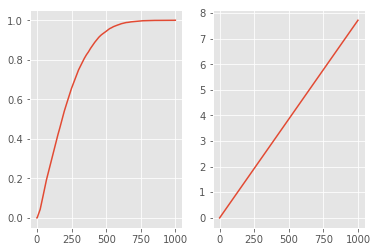

In [60]:
fig, ax = plt.subplots(ncols=2)
ax[0].plot(hcdf_ext)
ax[1].plot(hcdf_support)
plt.show()

In [61]:
X_uni = np.interp(X, hcdf_support, hcdf_ext)
X_uni.min(), X_uni.max()

(0.00022782884635635275, 0.9997000200000001)

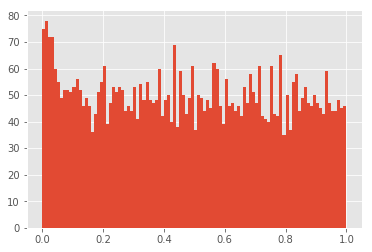

In [62]:
X_uni.min(), X_uni.max()

fig, ax = plt.subplots()

ax.hist(X_uni, bins=100)
plt.show()

### Transform

In [32]:
X_uni = np.interp(X, hcdf, hcdf_support)

ValueError: fp and xp are not of the same length.

#### Entropy Calculation

```python
idx = where(hpdf[1:-1] > 0.0, )
res = np.log(idx)
-np.sum(hpdf[1:-1] * res * bin_widths)
```